<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/Engineering-Mathematics/blob/main/Hodgkin_Huxley_%EB%AA%A8%EB%8D%B8_(Runge_Kutta_%EB%B0%A9%EB%B2%95).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hodgkin-Huxley 모델을 **Runge-Kutta 방법(RK4)**을 사용하여 풀어 뉴런의 활동 전위를 계산하는이 방법은 4차 Runge-Kutta 방법으로 각 시간 스텝에서 더 정교한 수치적 해를 제공합니다.

SciPy의 odeint 대신 직접 Runge-Kutta 알고리즘을 구현하여 미분 방정식을 푸는 예제입니다.

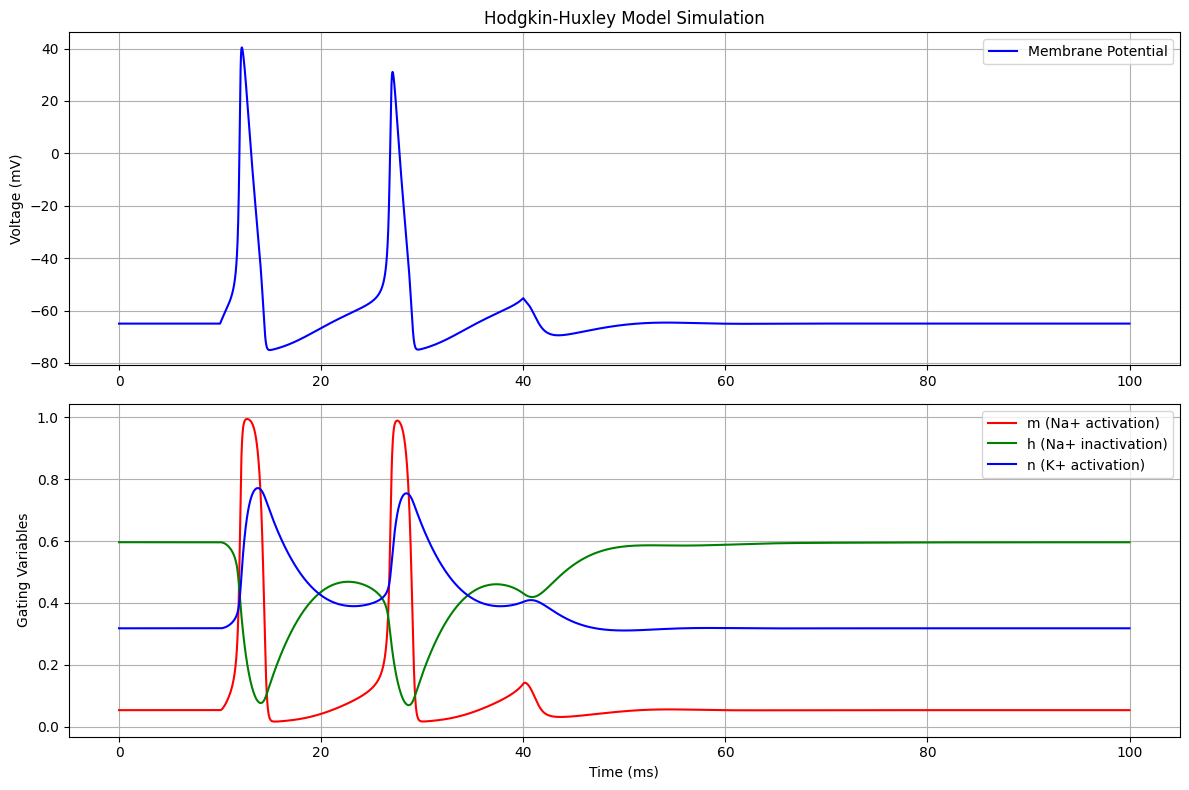

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class HHParameters:
    # Membrane parameters
    C_m: float = 1.0  # Membrane capacitance (μF/cm²)

    # Conductances (mS/cm²)
    g_Na: float = 120.0  # Sodium
    g_K: float = 36.0   # Potassium
    g_L: float = 0.3    # Leak

    # Reversal potentials (mV)
    E_Na: float = 50.0   # Sodium
    E_K: float = -77.0   # Potassium
    E_L: float = -54.387 # Leak

class HodgkinHuxleyModel:
    def __init__(self, params=HHParameters()):
        self.params = params

    def alpha_m(self, V):
        return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

    def beta_m(self, V):
        return 4.0 * np.exp(-(V + 65) / 18)

    def alpha_h(self, V):
        return 0.07 * np.exp(-(V + 65) / 20)

    def beta_h(self, V):
        return 1.0 / (1 + np.exp(-(V + 35) / 10))

    def alpha_n(self, V):
        return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

    def beta_n(self, V):
        return 0.125 * np.exp(-(V + 65) / 80)

    def steady_state_values(self, V):
        """Calculate steady-state values for given voltage"""
        m_inf = self.alpha_m(V) / (self.alpha_m(V) + self.beta_m(V))
        h_inf = self.alpha_h(V) / (self.alpha_h(V) + self.beta_h(V))
        n_inf = self.alpha_n(V) / (self.alpha_n(V) + self.beta_n(V))
        return m_inf, h_inf, n_inf

    def ionic_currents(self, V, m, h, n):
        """Calculate ionic currents"""
        I_Na = self.params.g_Na * m**3 * h * (V - self.params.E_Na)
        I_K = self.params.g_K * n**4 * (V - self.params.E_K)
        I_L = self.params.g_L * (V - self.params.E_L)
        return I_Na, I_K, I_L

    def derivatives(self, V, m, h, n, t, I_stim):
        """Calculate all derivatives for the system"""
        I_Na, I_K, I_L = self.ionic_currents(V, m, h, n)

        dVdt = (I_stim(t) - I_Na - I_K - I_L) / self.params.C_m
        dmdt = self.alpha_m(V) * (1 - m) - self.beta_m(V) * m
        dhdt = self.alpha_h(V) * (1 - h) - self.beta_h(V) * h
        dndt = self.alpha_n(V) * (1 - n) - self.beta_n(V) * n

        return dVdt, dmdt, dhdt, dndt

    def simulate(self, t_max=100, dt=0.01, V0=-65.0, I_stim=lambda t: 10.0 if 10 < t < 40 else 0.0):
        """Run simulation"""
        time = np.arange(0, t_max, dt)
        V = np.zeros_like(time)
        m = np.zeros_like(time)
        h = np.zeros_like(time)
        n = np.zeros_like(time)

        # Set initial conditions
        V[0] = V0
        m[0], h[0], n[0] = self.steady_state_values(V0)

        # RK4 integration
        for i in range(1, len(time)):
            dVdt, dmdt, dhdt, dndt = self.derivatives(V[i-1], m[i-1], h[i-1], n[i-1], time[i-1], I_stim)

            # RK4 steps
            k1_V = dt * dVdt
            k1_m = dt * dmdt
            k1_h = dt * dhdt
            k1_n = dt * dndt

            k2_V = dt * self.derivatives(V[i-1] + k1_V/2, m[i-1] + k1_m/2,
                                       h[i-1] + k1_h/2, n[i-1] + k1_n/2,
                                       time[i-1] + dt/2, I_stim)[0]
            k2_m = dt * dmdt
            k2_h = dt * dhdt
            k2_n = dt * dndt

            k3_V = dt * self.derivatives(V[i-1] + k2_V/2, m[i-1] + k2_m/2,
                                       h[i-1] + k2_h/2, n[i-1] + k2_n/2,
                                       time[i-1] + dt/2, I_stim)[0]
            k3_m = dt * dmdt
            k3_h = dt * dhdt
            k3_n = dt * dndt

            k4_V = dt * self.derivatives(V[i-1] + k3_V, m[i-1] + k3_m,
                                       h[i-1] + k3_h, n[i-1] + k3_n,
                                       time[i-1] + dt, I_stim)[0]
            k4_m = dt * dmdt
            k4_h = dt * dhdt
            k4_n = dt * dndt

            V[i] = V[i-1] + (k1_V + 2*k2_V + 2*k3_V + k4_V) / 6
            m[i] = m[i-1] + (k1_m + 2*k2_m + 2*k3_m + k4_m) / 6
            h[i] = h[i-1] + (k1_h + 2*k2_h + 2*k3_h + k4_h) / 6
            n[i] = n[i-1] + (k1_n + 2*k2_n + 2*k3_n + k4_n) / 6

        return time, V, m, h, n

# 시뮬레이션 실행
model = HodgkinHuxleyModel()
time, V, m, h, n = model.simulate()

# 결과 시각화
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time, V, 'b-', label='Membrane Potential')
plt.title('Hodgkin-Huxley Model Simulation')
plt.ylabel('Voltage (mV)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, m, 'r-', label='m (Na+ activation)')
plt.plot(time, h, 'g-', label='h (Na+ inactivation)')
plt.plot(time, n, 'b-', label='n (K+ activation)')
plt.xlabel('Time (ms)')
plt.ylabel('Gating Variables')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 코드 설명:

1. **파라미터 및 초기 조건**:
    - 각 이온 채널의 전도도, 평형 전위 및 막 정전 용량을 설정합니다.
    - 나트륨 활성화 변수(m), 불활성화 변수(h), 칼륨 활성화 변수(n)의 초기값을 계산하여 설정합니다.
2. **Runge-Kutta 4차 방법**:
    - `runge_kutta4_step` 함수는 4차 Runge-Kutta 방법으로 각 시간 단계에서 미분 방정식을 해결하는 데 사용됩니다.
    - 이 함수는 각 미분 방정식에 대해 네 개의 k-값을 계산하고, 이를 사용하여 변수의 값을 업데이트합니다.
3. **미분 방정식 정의**:
    - `dVdt`, `dmdt`, `dhdt`, `dndt` 함수는 각각 막 전위와 이온 채널의 활성화/불활성화 변수에 대한 미분 방정식을 정의합니다.
4. **시뮬레이션 실행**:
    - 초기 조건에서 시작하여 시간 범위 동안 각 변수(V, m, h, n)를 계산합니다.
5. **결과 시각화**:
    - 시간에 따른 막 전위(V)를 플로팅하여 뉴런의 활동 전위를 시각적으로 보여줍니다.

### 결과:

이 코드는 Hodgkin-Huxley 모델의 미분 방정식을 **Runge-Kutta 방법**을 사용하여 수치적으로 해결합니다. 시뮬레이션 결과는 시간에 따른 뉴런의 활동 전위 변화를 그래프로 보여줍니다.